<img src="https://www.epfl.ch/about/overview/wp-content/uploads/2020/07/logo-epfl-1024x576.png"
    style="padding-right:10px;width:140px;float:left">
<h2 style="white-space: nowrap">Neural Signal and Signal Processing (NX-421)</h2>
<hr style="clear:both">
<h1 style="colr:black">Miniproject 2 - Processing and analysis of EMG data</h1>
<h1 style="colr:black">Part 3</h1>
<h4 style="white-space: nowrap">Camille Dorster, Toufan Kashaev, Johan Bordet</h4>

## 1. Visualize & preprocess

In [19]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from scipy.io import loadmat
from scipy.ndimage import convolve1d
from scipy.signal import welch

In [20]:
data=loadmat('Dataset8/S1_E1_A1.mat')
print("Dataset variables:")
for key in data.keys():
    if not key.startswith('__'):
        print(key)

Dataset variables:
subject
exercise
emg
acc
gyro
mag
glove
stimulus
repetition
restimulus
rerepetition


In [40]:
emg_data = data['emg']
#inly take the part of th data where index is involved in the movement
restimulus = np.asarray(data["restimulus"]).flatten()
movement_indices = (restimulus > 0)
row_indices = np.where(movement_indices)[0]

emg_data = emg_data[movement_indices,:]
print("EMG data dimension:{}".format(emg_data.shape))
print("EMG data type: {}".format(emg_data.dtype))
print("data glove shape:", data["glove"].shape)
print("restimulus shape:", restimulus.shape)
print("movement indices shape:", movement_indices.shape)


EMG data dimension:(1104351, 16)
EMG data type: float32
data glove shape: (2292526, 18)
restimulus shape: (2292526,)
movement indices shape: (2292526,)


In [41]:
print(f"Full glove data dimension: {data['glove'].shape}")
# only regressing on finger joint 5 and 6. These are the PIP and DIP joints of the index finger
joint_angles_used=[3,6,8,11,14]
glove_data_index = data["glove"][row_indices,:][:,joint_angles_used]
print("Glove data dimension: {}".format(glove_data_index.shape))
print("Glove data type: {}".format(type(glove_data_index)))
print(f"shape of just two finger angles: {glove_data_index.shape}")

Full glove data dimension: (2292526, 18)
Glove data dimension: (1104351, 5)
Glove data type: <class 'numpy.ndarray'>
shape of just two finger angles: (1104351, 5)


Text(0, 0.5, 'Amplitude')

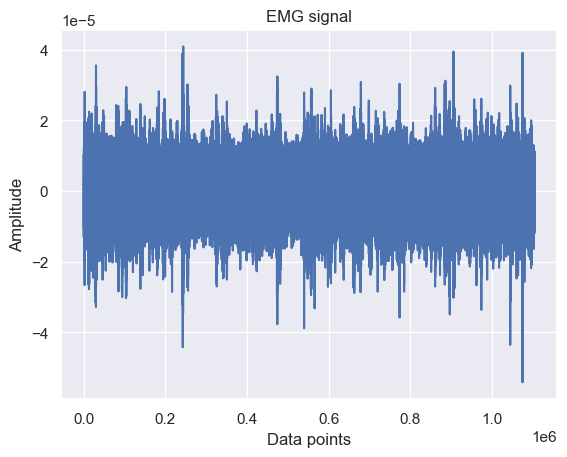

In [42]:
# Plot an EMG channel to get a sense of the data
plt.close("all")
fig, ax = plt.subplots()
ax.plot(emg_data[:, 3])   
ax.set_title("EMG signal")
ax.set_xlabel("Data points")
ax.set_ylabel("Amplitude")

Text(0.5, 1.0, 'Power Spectral Density plot in Log scale')

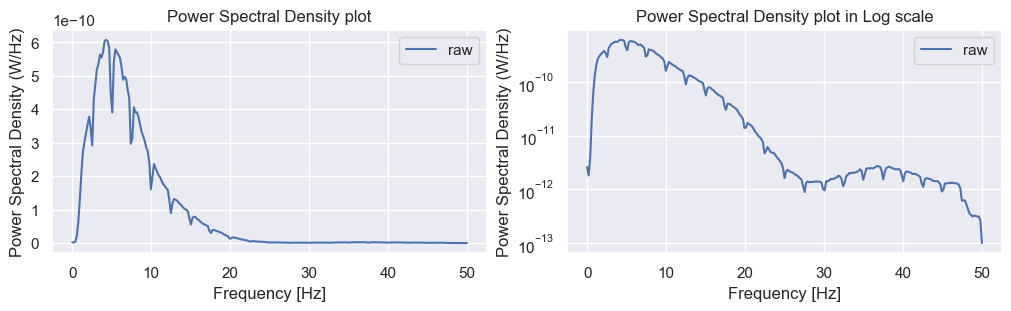

In [43]:
#Use Welch's method for power spectral density estimation, it reduces the variance of the estimate.

freqs_pre, Pxx_pre = welch(emg_data[:, 8], fs=100, nperseg=512)
plt.close("all")
fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(10, 3))
ax[0].plot(freqs_pre, Pxx_pre, label="raw")
ax[0].legend()
ax[0].set_xlabel("Frequency [Hz]")
ax[0].set_ylabel("Power Spectral Density (W/Hz)")
ax[0].set_title("Power Spectral Density plot")

ax[1].semilogy(freqs_pre, Pxx_pre, label="raw")
ax[1].legend()
ax[1].set_xlabel("Frequency [Hz]")
ax[1].set_ylabel("Power Spectral Density (W/Hz)")
ax[1].set_title("Power Spectral Density plot in Log scale")

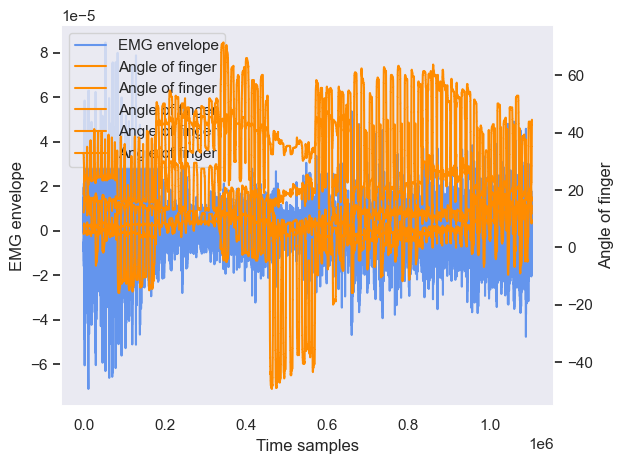

In [44]:
mov_mean_size = 50
mov_mean_weights = np.ones(mov_mean_size) / mov_mean_size
EMG_envelopes = convolve1d(emg_data, weights=mov_mean_weights, axis=0)

fig, ax = plt.subplots()
ax.plot(EMG_envelopes[:, 0],color = 'cornflowerblue', label="EMG envelope")
ax.set_ylabel("EMG envelope")
ax.set_xlabel("Time samples")
ax.grid(False)

finger_angle_ax = ax.twinx()
finger_angle_ax.plot(glove_data_index[:, :], color="darkorange", label="Angle of finger")
finger_angle_ax.set_ylabel("Angle of finger")
finger_angle_ax.grid(False)

# Get handles and labels for legend
emg_handles, emg_labels = ax.get_legend_handles_labels()
finger_angle_handles, finger_angle_labels = finger_angle_ax.get_legend_handles_labels()

# Combine handles and labels
combined_handles = emg_handles + finger_angle_handles
combined_labels = emg_labels + finger_angle_labels

# Create a single legend
ax.legend(combined_handles, combined_labels, loc='upper left')
plt.tight_layout()

In [45]:
from sklearn.model_selection import train_test_split

# Chronologically cut the whole dataset before creating overlapping windows
EMG_train, EMG_test, Labels_train, Labels_test = train_test_split(emg_data, glove_data_index, test_size=0.2, shuffle=False)

In [46]:
print(f"EMG train data shape: {EMG_train.shape},    Train label shape: {Labels_train.shape}")
print(f"EMG test data shape: {EMG_test.shape},      Test label shape: {Labels_test.shape}")

EMG train data shape: (883480, 16),    Train label shape: (883480, 5)
EMG test data shape: (220871, 16),      Test label shape: (220871, 5)


In [47]:
fs = 100  # [Hz], from dataset description
emg_window_length_sec = 200e-3  # [s]
incremental_window_length_sec = 40e-3  # [s]

In [48]:
def extract_time_windows_regression(EMG: np.ndarray, Label: np.ndarray, fs: int, win_len: int, step: int):
# This function is used to cut the time windows from the raw EMG 
# It return a lists containing the EMG of each time window.
# It also returns the target corresponding to the time of the end of the window
    """
    This function is defined to perform an overlapping sliding window 
    :param EMG: Numpy array containing the data
    :param Label: Numpy array containing the targets
    :param fs: the sampling frequency of the signal
    :param win_len: The size of the windows (in seconds)
    :param step: The step size between windows (in seconds)

    :return: A Numpy array containing the windows
    :return: A Numpy array containing the targets aligned for each window
    :note: The lengths of both outputs are the same
    """
    
    n,m = EMG.shape
    win_len = int(win_len*fs)
    start_points = np.arange(0,n-win_len,int(step*fs))
    end_points = start_points + win_len

    EMG_windows = np.zeros((len(start_points),win_len,m))
    Labels_window = np.zeros((len(start_points),win_len,Label.shape[1]))
    for i in range(len(start_points)):
        EMG_windows[i,:,:] = EMG[start_points[i]:end_points[i],:]
        Labels_window[i,:,:] = Label[start_points[i]:end_points[i],:]
    

    return EMG_windows, Labels_window

In [49]:
# extract over lapping time windows on train set and test set
EMG_train_windows, Labels_train_windows = extract_time_windows_regression(EMG_train, Labels_train, fs, emg_window_length_sec, incremental_window_length_sec)

EMG_test_windows, Labels_test_windows = extract_time_windows_regression(EMG_test, Labels_test, fs, emg_window_length_sec, incremental_window_length_sec)


print(f"EMG train windows shape: {EMG_train_windows.shape}, Train label windows shape: {Labels_train_windows.shape}")
print(f"EMG test windows shape: {EMG_test_windows.shape},   Test label windows shape: {Labels_test_windows.shape}")

EMG train windows shape: (220865, 20, 16), Train label windows shape: (220865, 20, 5)
EMG test windows shape: (55213, 20, 16),   Test label windows shape: (55213, 20, 5)


In [50]:
def extract_features(EMG_windows: np.ndarray, Labels_windows: np.ndarray):
    """
    This function is defined to extract the mean and standard deviation of each window
    :param EMG_windows: A Numpy array containing the windows
    :return: A Numpy array containing the mean, the standard deviation and the maximum amplitude of each window and the mean of the labels window
    """
    # along axis 1, which is the time axis
    EMG_mean = np.mean(EMG_windows,axis=1)
    EMG_std = np.std(EMG_windows,axis=1)
    EMG_max_amplitude = np.max(EMG_windows, axis=1)
    Labels_mean = np.mean(Labels_windows,axis=1)
    
    # Concatenate the mean and std of each window
    EMG_extracted_features = np.concatenate((EMG_mean, EMG_std, EMG_max_amplitude), axis=1)
    return EMG_extracted_features, Labels_mean

In [51]:
EMG_train_extracted_features, Labels_train_mean = extract_features(EMG_train_windows,Labels_train_windows)
EMG_test_extracted_features, Labels_test_mean = extract_features(EMG_test_windows,Labels_test_windows)

print("EMG train extracted features shape: {}, Finger labels feature shape:{}".format(EMG_train_extracted_features.shape, Labels_train_mean.shape))
print("EMG test extracted features shape: {}, Finger labels feature shape:{}".format(EMG_test_extracted_features.shape, Labels_test_mean.shape))

EMG train extracted features shape: (220865, 48), Finger labels feature shape:(220865, 5)
EMG test extracted features shape: (55213, 48), Finger labels feature shape:(55213, 5)


## Gradient Boosting Regression

In [54]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor

# 1. Initialize the Gradient Boosting Regressor (the base estimator)
# It's good practice to set parameters for better performance and stability
gbr_base = GradientBoostingRegressor()

# 2. Wrap the base regressor with MultiOutputRegressor
# This allows the model to handle your (N, 5) Labels_train_mean array
regressor = MultiOutputRegressor(gbr_base)

# 3. Fit the model (The fitting process is now multi-output compatible)
# Labels_train_mean is your (220865, 5) array
regressor.fit(EMG_train_extracted_features, Labels_train_mean)

# 4. Predict using the Gradient Boosting Regressor (Output will also be (N, 5))
y_pred_gradient_boosting = regressor.predict(EMG_test_extracted_features)

print("Gradient Boosting model successfully trained for 5 outputs.")
print(f"Prediction shape: {y_pred_gradient_boosting.shape}")



KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

# Define the original joint indices for display in the titles
original_joint_indices = [3, 6, 8, 11, 14]

plt.close("all")
# Create 5 subplots in a single column
fig, ax = plt.subplots(5, 1, figsize=(12, 12)) 

fig.tight_layout() 
fig.subplots_adjust(top=0.9)
fig.suptitle("**Gradient Boosting Regressor Performance: 5 Joint Angles**", fontsize=16)

# --- Plotting Joint 3 (Column 0) ---
ax[0].plot(Labels_test_mean[:, 0], label="True")
ax[0].plot(y_pred_gradient_boosting[:, 0], linestyle="--", label="Predicted")
ax[0].set_title(f"Joint {original_joint_indices[0]} (Index 0), True Labels vs Predictions")
ax[0].legend()
ax[0].set_ylabel("Angle Value")

# --- Plotting Joint 6 (Column 1) ---
ax[1].plot(Labels_test_mean[:, 1], label="True")
ax[1].plot(y_pred_gradient_boosting[:, 1], linestyle="--", label="Predicted")
ax[1].set_title(f"Joint {original_joint_indices[1]} (Index 1), True Labels vs Predictions")
ax[1].legend()
ax[1].set_ylabel("Angle Value")

# --- Plotting Joint 8 (Column 2) ---
ax[2].plot(Labels_test_mean[:, 2], label="True")
ax[2].plot(y_pred_gradient_boosting[:, 2], linestyle="--", label="Predicted")
ax[2].set_title(f"Joint {original_joint_indices[2]} (Index 2), True Labels vs Predictions")
ax[2].legend()
ax[2].set_ylabel("Angle Value")

# --- Plotting Joint 11 (Column 3) ---
ax[3].plot(Labels_test_mean[:, 3], label="True")
ax[3].plot(y_pred_gradient_boosting[:, 3], linestyle="--", label="Predicted")
ax[3].set_title(f"Joint {original_joint_indices[3]} (Index 3), True Labels vs Predictions")
ax[3].legend()
ax[3].set_ylabel("Angle Value")

# --- Plotting Joint 14 (Column 4) ---
ax[4].plot(Labels_test_mean[:, 4], label="True")
ax[4].plot(y_pred_gradient_boosting[:, 4], linestyle="--", label="Predicted")
ax[4].set_title(f"Joint {original_joint_indices[4]} (Index 4), True Labels vs Predictions")
ax[4].legend()
ax[4].set_ylabel("Angle Value")
ax[4].set_xlabel("Time Step (Sample Index)")


plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

# Calculate the Mean Squared Error
MSE_gradient_boosting = mean_squared_error(Labels_test_mean, y_pred_gradient_boosting)

print(f"Mean Squared Error (Gradient Boosting): {MSE_gradient_boosting:.4f}")